In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys

In [2]:
sys.path

['d:\\Desktop\\Lipschitz_DSNN\\trial_notebooks',
 'd:\\anaconda_neel\\python38.zip',
 'd:\\anaconda_neel\\DLLs',
 'd:\\anaconda_neel\\lib',
 'd:\\anaconda_neel',
 '',
 'd:\\anaconda_neel\\lib\\site-packages',
 'd:\\anaconda_neel\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'd:\\anaconda_neel\\lib\\site-packages\\win32',
 'd:\\anaconda_neel\\lib\\site-packages\\win32\\lib',
 'd:\\anaconda_neel\\lib\\site-packages\\Pythonwin',
 'd:\\anaconda_neel\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\NEELKANTH RAWAT\\.ipython']

In [3]:
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

Now I can start loading up the module and data and try to replicate some of the examples to understand the algorithm well

In [4]:
# let's load a saved configuration
import json

In [5]:
# Load the JSON file
file_config_training="D:\Desktop\Lipschitz_DSNN\configs\config_1d.json"
with open(file_config_training, 'r') as f:
    config = json.load(f)

config

{'activation_fn_params': {'activation_type': 'linearspline',
  'groupsort_groupsize': 5,
  'prelu_init': -1,
  'lipschitz_constrained': True,
  'spline_init': 'relu',
  'spline_range': 0.5,
  'spline_scaling_coeff': True,
  'spline_size': 101,
  'lmbda': 1e-07},
 'dataset': {'function_type': 'f1',
  'number_knots': 9,
  'testing_dataset_size': 10000,
  'training_dataset_size': 1000},
 'exp_name': 'test',
 'log_dir': '1d_exps/ortho',
 'net_params': {'bias': True,
  'layer_sizes': [1, 10, 10, 10, 1],
  'projection': 'orthonormalize',
  'weight_initialization': 'He_uniform'},
 'optimizer': {'lr_spline_coeffs': 5e-05,
  'lr_spline_scaling_coeffs': 0.0005,
  'lr_weights': 0.002},
 'seed': 5,
 'training_options': {'batch_size': 10,
  'epochs': 1000,
  'nbr_models': 25,
  'num_workers': 1}}

`BaseModel.py` and `simple_fc.py`: For Simple Fully Connected network

In [6]:
from architectures.simple_fc import SimpleFC

In [7]:
import torch
import torch.nn as nn
from architectures.base_model import BaseModel
from layers.lipschitzlinear import LipschitzLinear
from projections.fc_projections import identity, bjorck_orthonormalize_fc


class SimpleFCClassification(BaseModel):
    """simple architecture for a fully-connected network"""
    def __init__(self, network_parameters, **params):
        
        super().__init__(**params)

        modules = nn.ModuleList()

        if network_parameters['projection'] == 'no_projection':
            print("no orthonormalisation. projection= identity")
            projection = identity
        elif network_parameters['projection'] == 'orthonormalize':
            print("Orthonormalisation will take place.")
            if 'bjorck_iter' in network_parameters:
                def proj(weights, lipschitz_goal):
                    return bjorck_orthonormalize_fc(weights, lipschitz_goal,
                                                    beta=0.5, iters=network_parameters['bjorck_iter'])
                projection = proj
            else:
                projection = bjorck_orthonormalize_fc
        else:
            raise ValueError('Projection type is not valid')

        layer_sizes = network_parameters['layer_sizes']


        for i in range(len(layer_sizes)-2):
            modules.append(LipschitzLinear(1, projection, layer_sizes[i], layer_sizes[i+1]))
            modules.append(self.init_activation(('fc', layer_sizes[i+1])))


        modules.append(LipschitzLinear(1, projection, layer_sizes[-2], layer_sizes[-1]))
        modules.append(nn.Sigmoid())
        self.initialization(init_type=network_parameters['weight_initialization'])
        self.num_params = self.get_num_params()

        self.layers = nn.Sequential(*modules)
        

    def forward(self, x):
        """ """
        ### apply layers and sigmoid function
        x= self.layers(x)
        #x = torch.sigmoid(x)
        return x

Area Classification Problem

# class 0 DPs: 1502 and # class 1 DPs: 498 


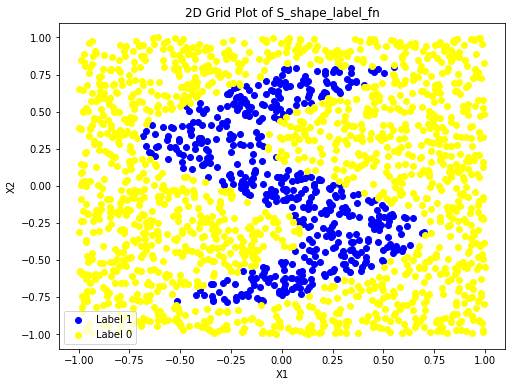

In [8]:
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# Generate random x_mat
num_dp = 2000  # Assuming num_dp is defined
x_mat = np.random.uniform(-1.0, 1.0, size=(num_dp, 2))

# Create y_mat
y_mat = S_shape_label_fn(x_mat)

##
num_zeros=np.count_nonzero(y_mat==0)
num_ones=np.count_nonzero(y_mat==1)
print(f"# class 0 DPs: {num_zeros} and # class 1 DPs: {num_ones} ")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat[y_mat == 1, 0], x_mat[y_mat == 1, 1], color='blue', label='Label 1')
plt.scatter(x_mat[y_mat == 0, 0], x_mat[y_mat == 0, 1], color='yellow', label='Label 0')
plt.title('2D Grid Plot of S_shape_label_fn')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.grid(True)
plt.show()

In [9]:
from torch.utils.data import Dataset
### later transfer it to the 
class CustomDataset(Dataset):
    """
    Custom dataset class for our problem.
    """
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y


In [10]:
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils import tensorboard
from architectures.simple_fc import SimpleFC
from utils import metrics, utilities, spline_utils
import matplotlib.pyplot as plt
from layers.lipschitzlinear import LipschitzLinear
from dataloader.Function_1D import (Function1D, generate_testing_set,
    slope_1_ae, slope_1_flat, cosines, threshold)
from activations.linearspline import LinearSpline

In [11]:
def slope_normalization(cs, T):
    lipschitz = torch.max(torch.abs(cs[:, 1:] - cs[:,:-1]), dim=1)[0]
    new_cs = T * torch.div(cs.T, lipschitz).T

    return new_cs

In [12]:
# writing a general trainer function for our classification problem
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
from utils import metrics, utilities

class Trainer_classification:
    """
    Trainer class for your classification problem.
    """
    def __init__(self, model, xdata, ydata, criterion, config, seed, device, print_after_epoch=5):
        self.model = model
        self.x = xdata
        self.y = ydata
        self.config = config
        self.device = device
        self.criterion = criterion 

        # Split dataset into train and validation sets
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(xdata, ydata,
                                                                    test_size=config["training_options"]["validation_split"], 
                                                                    random_state=seed)
        
        # Print number of DPs of class 0 and 1 in train and val set
        ### let's count number of datapoints for class 0 and 1
        print(f"in Train set: # class 0 DPs: {np.count_nonzero(self.y_train==0)} and # class 1 DPs: {np.count_nonzero(self.y_train==1)}")
        print(f"in val set: # class 0 DPs: {np.count_nonzero(self.y_val==0)} and # class 1 DPs: {np.count_nonzero(self.y_val==1)}")
        # Prepare dataloaders 
        self.train_dataloader = DataLoader(CustomDataset(self.x_train, self.y_train), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=True)
        self.val_dataloader = DataLoader(CustomDataset(self.x_val, self.y_val), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=False)

        # Set up the optimizer 
        self.set_optimization()

        # average train and val epoch loss
        self.avg_train_loss_epoch=[]
        self.avg_val_loss_epoch = []
        self.train_acc_epoch = []
        self.val_acc_epoch = []


        ## for printing the result
        self.print_after=print_after_epoch

        # Stats to save about the models

    ### setting up the optimizer
    def set_optimization(self):
        """ """
        #for i in range(self.nbr_models):
        params_list = [{'params': spline_utils.get_no_spline_coefficients(self.model), \
                        'lr': self.config["optimizer"]["lr_weights"]}]
        if self.model.using_splines:
            params_list.append({'params': spline_utils.get_spline_coefficients(self.model), \
                                'lr': self.config["optimizer"]["lr_spline_coeffs"]})

            if self.config["activation_fn_params"]["spline_scaling_coeff"]:
                params_list.append({'params': spline_utils.get_spline_scaling_coeffs(self.model), \
                                    'lr': self.config["optimizer"]["lr_spline_scaling_coeffs"]})
        self.optimizer = torch.optim.Adam(params_list, weight_decay=0.0001)

    def train(self):
        """
        Main training loop.
        """
        for epoch in range(self.config["training_options"]["epochs"]):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)
            if (epoch+1) % self.print_after ==0 :
                print("_"*30)
                print(f"avg epoch train loss: {self.avg_train_loss_epoch[epoch]:.6f} and validation loss: {self.avg_val_loss_epoch[epoch]:.6f}")
                print(f"training acc: {self.train_acc_epoch[epoch]:.6f} and validation acc: {self.val_acc_epoch[epoch]:.6f}")
                print("_"*30)
        # Need to add Additional post-training actions here
        ### (right now I dont wanna save my checkpoints)

    def train_epoch(self, epoch):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_train_loss=0
        tbar = tqdm(self.train_dataloader)
        for batch_idx, (data, target) in enumerate(tbar): #(self.train_dataloader):
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            output = self.model(data)### output shape: (N,1)
            output = output.squeeze()

            # Compute loss
            data_loss = self.criterion(output, target.float())

            # TV2 regulatisation
            regularization=0
            if self.model and self.config['activation_fn_params']['lmbda'] > 0:
                regularization = self.config['activation_fn_params']['lmbda'] * self.model.TV2()
            # total loss
            total_loss = data_loss + regularization#data_loss #+ regularization
            ### Yippie I figured out the issue. it is with the data_loss term 

            # Backward pass and optimization
            self.optimizer.zero_grad()
            total_loss.backward()
            # update the parameters
            self.optimizer.step()

            total_train_loss+=total_loss
            # If need to add code to Log training progress
            # my training progress logging code goes here

        # average training loss for the epoch
        avg_train_loss = total_train_loss / len(self.train_dataloader)
        self.avg_train_loss_epoch.append(avg_train_loss.detach())

        # evaluating training accuracy
        with torch.no_grad():
            pred= self.model(torch.tensor(self.x_train))
            acc_train  = (pred.squeeze().round() == torch.tensor(self.y_train) ).float().mean()
            self.train_acc_epoch.append(acc_train)
        

    def validate_epoch(self, epoch):
        """
        Validate the model for one epoch.
        """
        self.model.eval()
        total_val_loss=0
        # Validation loop
        with torch.no_grad():
            for data, target in self.val_dataloader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                output = self.model(data)
                output = output.squeeze()

                # Compute validation metrics (e.g., accuracy, loss)
                data_loss = self.criterion(output, target.float())
                total_val_loss+=data_loss

            avg_val_loss = total_val_loss / len(self.val_dataloader)
            self.avg_val_loss_epoch.append(avg_val_loss.detach())
            # # Calculating accuracy of model
            # acc_val  = (output.round() == target).float().mean
            # self.val_acc_epoch.append(acc_val)
            # evaluating training accuracy
            pred= self.model(torch.tensor(self.x_val))
            acc_val  = (pred.squeeze().round() == torch.tensor(self.y_val) ).float().mean()
            self.val_acc_epoch.append(acc_val)
            # Additional validation actions go here
        

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        # Your checkpoint saving code goes here

    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint.
        """
        # Your checkpoint loading code goes here

    # Additional methods for logging, evaluation, etc. go here


In [13]:
### plotting the confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predicted_labels, true_labels, classes):
    """
    Plot confusion matrix.
    
    Parameters:
    predicted_labels : numpy array
        Predicted labels.
    true_labels : numpy array
        True labels.
    classes : list
        List of class labels.
    """
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add counts in the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
### code to plot the results of training (like epoch losses and accuracy)
def plot_losses_trained_model(trainer):
    
    # Plotting losses
    train_loss = trainer.avg_train_loss_epoch
    val_loss = trainer.avg_val_loss_epoch
    plt.plot(train_loss, "o-", label="train_loss")
    plt.plot(val_loss, ">:", label="val_loss")
    plt.legend()
    plt.show()

    # Plotting train and validation accuracy
    train_acc, val_acc = trainer.train_acc_epoch, trainer.val_acc_epoch
    plt.plot(train_acc, "o-", label="train_accuracy")
    plt.plot(val_acc, ">:", label="val_accuracy")
    plt.yscale("log")
    plt.legend()
    plt.show()

    # Printing the final training and validation accuracy
    print(f"Final training accuracy is: {train_acc[-1]:0.3f}")
    print(f"Final validation accuracy is: {val_acc[-1]:0.3f}")


### function to evaluate the trained model
def evaluate_model(trained_model_input, y_test_fn, dataset_size=100, noise_level=0.003, 
                    want_confusion_matrix=False,
                    print_preds=False):
    # Generate test dataset
    x_test = np.random.uniform(-1, 1, size=(dataset_size, 2)) + noise_level * np.ones(shape=(dataset_size, 2))
    y_test = y_test_fn(x_test)

    # Convert to torch tensors
    x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

    # Make predictions
    with torch.no_grad():
        preds = trained_model_input(x_test)
        if print_preds:
            print("predictions are:")
            print(preds)

    # Calculate accuracy
    acc_test = (preds.squeeze().round() == y_test).float().mean()
    print(f"Test accuracy: {acc_test.item():.4f}")
    # Plot confusion matrix
    if want_confusion_matrix:
        plot_confusion_matrix(preds.squeeze().round(), y_test, classes=["0", "1"])


In [15]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [2, 10, 1], ### we will consider 2-D Example later on
    'projection': 'no_projection' , ### Let's change it from 'orthonormalize' to 'no_projection'
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # idk what exactly is this. Need to look into it well
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002, i changed it to 0.01

training_options = {'batch_size': 64*5,  
    'epochs': 600,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.3}

config_train_classification = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "S shaped classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}



~~Issue I am facing at the moment: No gradients are being evaluated for the weights and biases. So we are never learning any parameters which could be the reason why the loss is not decreasing.~~

Without Bjork orthonormalisation of linear layers and unbalanced dataset:

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=10, bias=True)
    (1): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 1055 and # class 1 DPs: 345
in val set: # class 0 DPs: 447 and # class 1 DPs: 153


100%|██████████| 5/5 [00:00<00:00, 41.30it/s]


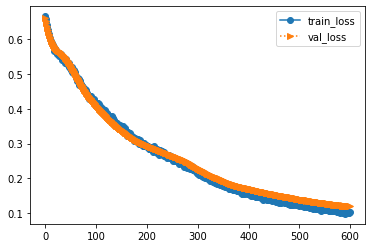

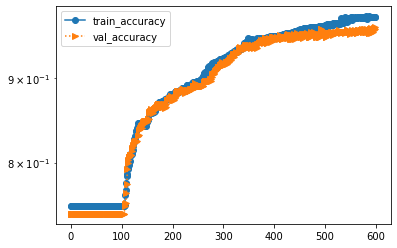

Final training accuracy is: 0.980
Final validation accuracy is: 0.967
---------Trained model's (with no orthonormalisation and trained on heavily unbalanced TS) performance on the test data-----------
test number: 1
Test accuracy: 0.9900


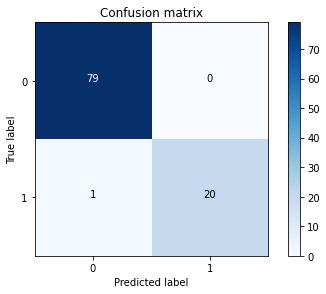

test number: 2
Test accuracy: 0.9700


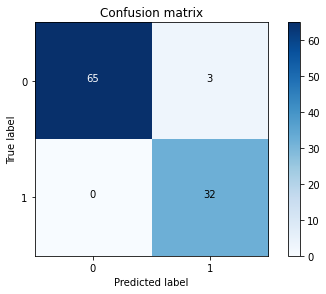

test number: 3
Test accuracy: 0.9800


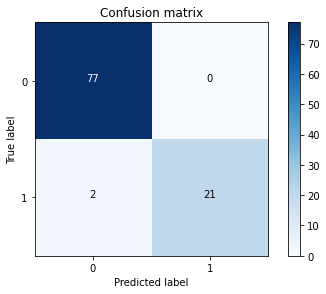

test number: 4
Test accuracy: 0.9900


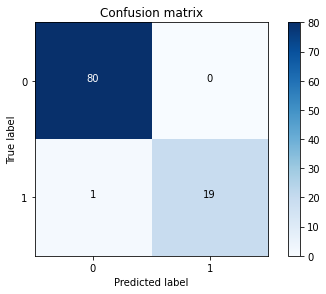

test number: 5
Test accuracy: 0.9700


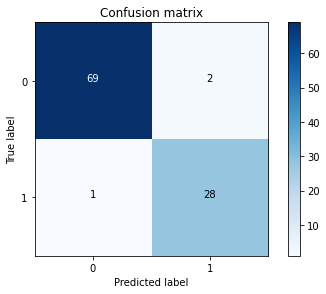

In [16]:
# Define the criterion
criterion = nn.BCELoss()

# Define the model
ds_simple_fc_model= SimpleFCClassification(network_parameters=config_train_classification['net_params'], **additional_network_params)
ds_simple_fc_model = ds_simple_fc_model.to('cpu')
print("Model is:")
print(ds_simple_fc_model)

# Instantiate the Trainer
trainer_no_bjork = Trainer_classification(model=ds_simple_fc_model,
                                    xdata=x_mat,
                                    ydata=y_mat,
                                    criterion=criterion,
                                    config=config_train_classification,
                                    seed=12,
                                    device='cpu',
                                    print_after_epoch=1000
                                    )

# Train the model
trainer_no_bjork.train()

### plotting loss curves
plot_losses_trained_model(trainer_no_bjork)

### evaluating the trained model's performance on the test dataset
print("---------Trained model's (with no orthonormalisation and trained on heavily unbalanced TS) performance on the test data-----------")
for i in range(0,5):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_model, S_shape_label_fn, want_confusion_matrix=True)

WITH bjork orthonormalisation:

In [17]:
### creating a new configuration for training the model with bjork orthonormalisation
import copy

config_train_classification_bjork= copy.deepcopy(config_train_classification)
config_train_classification_bjork['net_params']['projection']='orthonormalize'
print("old dict:"); print(config_train_classification)
print("new dict:"); print(config_train_classification_bjork)

old dict:
{'activation_fn_params': {'activation_type': 'linearspline', 'groupsort_groupsize': 5, 'prelu_init': -1, 'lipschitz_constrained': True, 'spline_init': 'relu', 'spline_range': 0.9, 'spline_scaling_coeff': True, 'spline_size': 19, 'lmbda': 1e-07}, 'exp_name': 'S shaped classification', 'net_params': {'bias': True, 'layer_sizes': [2, 10, 1], 'projection': 'no_projection', 'weight_initialization': 'He_uniform'}, 'optimizer': {'lr_spline_coeffs': 5e-05, 'lr_spline_scaling_coeffs': 0.0005, 'lr_weights': 0.002}, 'training_options': {'batch_size': 320, 'epochs': 600, 'nbr_models': 1, 'num_workers': 1, 'validation_split': 0.3}}
new dict:
{'activation_fn_params': {'activation_type': 'linearspline', 'groupsort_groupsize': 5, 'prelu_init': -1, 'lipschitz_constrained': True, 'spline_init': 'relu', 'spline_range': 0.9, 'spline_scaling_coeff': True, 'spline_size': 19, 'lmbda': 1e-07}, 'exp_name': 'S shaped classification', 'net_params': {'bias': True, 'layer_sizes': [2, 10, 1], 'projection'

 60%|██████    | 3/5 [00:00<00:00, 23.58it/s]

Orthonormalisation will take place.
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=10, bias=True)
    (1): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 1055 and # class 1 DPs: 345
in val set: # class 0 DPs: 447 and # class 1 DPs: 153


100%|██████████| 5/5 [00:00<00:00, 27.36it/s]


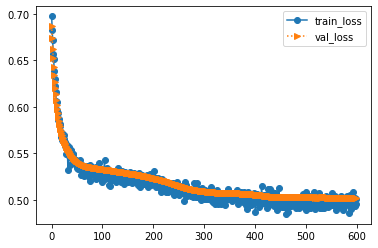

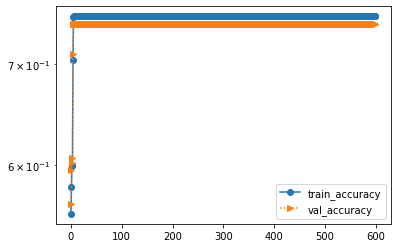

Final training accuracy is: 0.754
Final validation accuracy is: 0.745
---------------Trained model's (with bjork orthonormalisation, trained on heavily unbalanced TS) performance on the test dataset---------------
test number: 1
Test accuracy: 0.7800


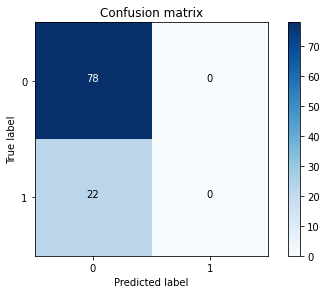

test number: 2
Test accuracy: 0.7600


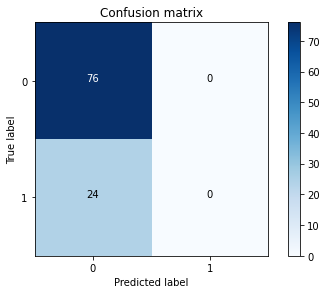

test number: 3
Test accuracy: 0.7300


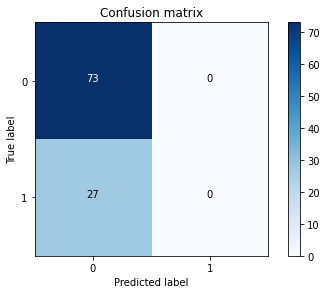

test number: 4
Test accuracy: 0.7800


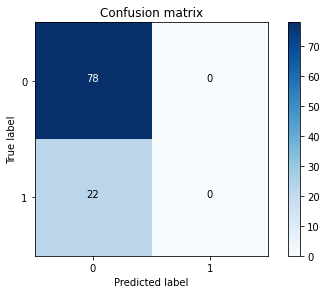

test number: 5
Test accuracy: 0.7400


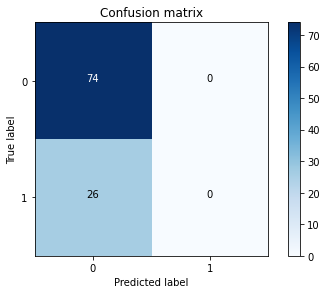

In [18]:
## data is : x_mat, y_mat: unbalanced dataset
## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_bjork_model= SimpleFCClassification(network_parameters=config_train_classification_bjork['net_params'],
                             **additional_network_params)
ds_simple_fc_bjork_model =ds_simple_fc_bjork_model.to('cpu')
print("model is:"); print(ds_simple_fc_bjork_model)

### instantiate the Trainer 
trainer_classification_bjork = Trainer_classification(model=ds_simple_fc_bjork_model,
                                                xdata=x_mat,
                                                ydata= y_mat,
                                                criterion=criterion,
                                                config= config_train_classification_bjork,
                                                seed=12,
                                                device='cpu',
                                                print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                )

### Let's train the model
trainer_classification_bjork.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork)

### evaluating the trained model's performance on the test dataset
print("---------------Trained model's (with bjork orthonormalisation, trained on heavily unbalanced TS) performance on the test dataset---------------")
for i in range(0,5):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_bjork_model, S_shape_label_fn, want_confusion_matrix=True)

Conclusion so far: For unbalanced dataset, the results are not good with 'bjork_orthonormalization'. They are relatively better for the model without 'orthonomalization'.

Is this the artifact of unbalanced dataset, if I swtich the label, then what happens? let's see (does the output is now still always 0, like the case before?)

# class 0 DPs: 477 and # class 1 DPs: 1523 


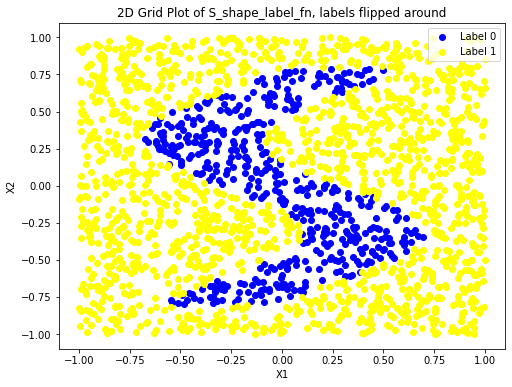

In [19]:
### data with labels switched
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn2(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    #return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)
    return np.logical_not(np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8)).astype(int)

# Generate random x_mat
num_dp = 2000  # Assuming num_dp is defined
x_mat2 = np.random.uniform(-1.0, 1.0, size=(num_dp, 2))

# Create y_mat
y_mat2 = S_shape_label_fn2(x_mat2)

##
num_zeros=np.count_nonzero(y_mat2==0)
num_ones=np.count_nonzero(y_mat2==1)
print(f"# class 0 DPs: {num_zeros} and # class 1 DPs: {num_ones} ")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_mat2[y_mat2 == 0, 0], x_mat2[y_mat2 == 0, 1], color='blue', label='Label 0')
plt.scatter(x_mat2[y_mat2 == 1, 0], x_mat2[y_mat2 == 1, 1], color='yellow', label='Label 1')
plt.title('2D Grid Plot of S_shape_label_fn, labels flipped around')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.grid(True)
plt.show()

100%|██████████| 5/5 [00:00<00:00, 31.50it/s]

Orthonormalisation will take place.
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=10, bias=True)
    (1): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 334 and # class 1 DPs: 1066
in val set: # class 0 DPs: 143 and # class 1 DPs: 457



100%|██████████| 5/5 [00:00<00:00, 30.34it/s]


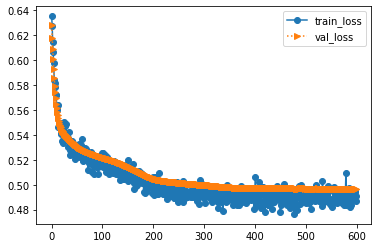

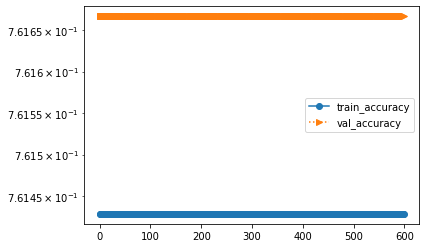

Final training accuracy is: 0.761
Final validation accuracy is: 0.762
-----Trained model's (with bjork orthonormalisation, trained on heavily unbalanced TS) performance on the test data but labels reversed----
test number: 1
Test accuracy: 0.8000


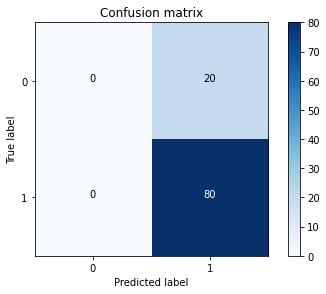

test number: 2
Test accuracy: 0.8400


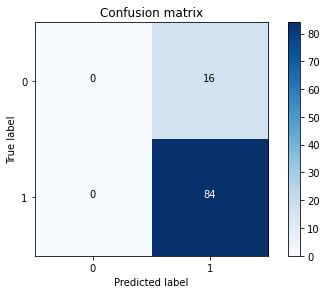

test number: 3
Test accuracy: 0.7500


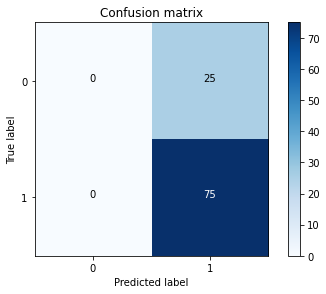

test number: 4
Test accuracy: 0.7600


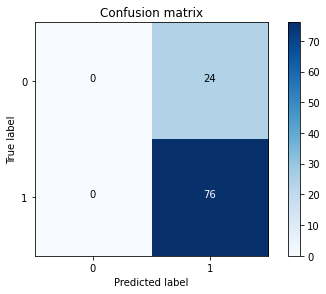

test number: 5
Test accuracy: 0.7800


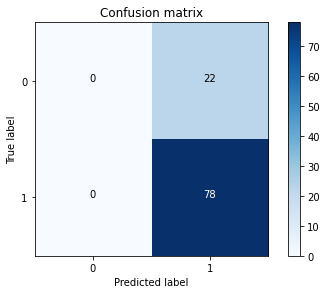

In [20]:
### labels are switched
import torch.nn as nn

# Define the criterion
criterion = nn.BCELoss()

# Define the model
ds_simple_fc_bjork2_model = SimpleFCClassification(network_parameters=config_train_classification_bjork['net_params'],
                                                   **additional_network_params)
ds_simple_fc_bjork2_model = ds_simple_fc_bjork2_model.to('cpu')
print("Model is:"); print(ds_simple_fc_bjork2_model)

# Instantiate the Trainer
trainer_classification_bjork2 = Trainer_classification(model=ds_simple_fc_bjork2_model,
                                                    xdata=x_mat2,
                                                    ydata=y_mat2,
                                                    criterion=criterion,
                                                    config=config_train_classification_bjork,
                                                    seed=12,
                                                    device='cpu',
                                                    print_after_epoch=1000  # I don't want to print because I am plotting them in the end anyways
                                                    )

# Train the model
trainer_classification_bjork2.train()

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork2)

### evaluating the trained model's performance on the test dataset
print("-----Trained model's (with bjork orthonormalisation, trained on heavily unbalanced TS) performance on the test data but labels reversed----")
for i in range(0,5):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_bjork2_model, S_shape_label_fn2, 
                want_confusion_matrix=True, print_preds=False)


So the output of the model-with-orthonormalisation is now switched to one. Could it be the artifact of our training data being unbalanced? What happens when our dataset is balanced?

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5 * x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# Function to generate a balanced dataset
def generate_balanced_data(num_dp_per_class):
    x_data = []
    y_data = []
    num_class_0 = 0
    num_class_1 = 0
    
    while num_class_0 < num_dp_per_class or num_class_1 < num_dp_per_class:
        x_candidate = np.random.uniform(-1.0, 1.0, size=(1, 2))
        y_candidate = S_shape_label_fn(x_candidate)
        
        if y_candidate == 0 and num_class_0 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_0 += 1
        elif y_candidate == 1 and num_class_1 < num_dp_per_class:
            x_data.append(x_candidate)
            y_data.append(y_candidate)
            num_class_1 += 1

    x_data = np.vstack(x_data)
    y_data = np.concatenate(y_data)
    return x_data, y_data

# Generate balanced data
num_dp_per_class = 1000  # Number of data points per class
x_mat3, y_mat3 = generate_balanced_data(num_dp_per_class)

# Count the number of data points for each class
num_zeros = np.count_nonzero(y_mat3 == 0)
num_ones = np.count_nonzero(y_mat3 == 1)
print(f"# class 0 DPs: {num_zeros} and # class 1 DPs: {num_ones}")


# class 0 DPs: 1000 and # class 1 DPs: 1000


  0%|          | 0/5 [00:00<?, ?it/s]

Orthonormalisation will take place.
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=10, bias=True)
    (1): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 720 and # class 1 DPs: 680
in val set: # class 0 DPs: 280 and # class 1 DPs: 320


100%|██████████| 5/5 [00:00<00:00, 24.19it/s]


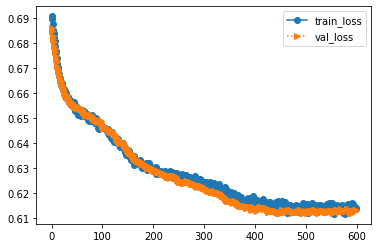

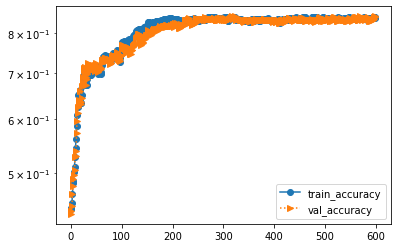

Final training accuracy is: 0.844
Final validation accuracy is: 0.843
--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------
test number: 1
Test accuracy: 0.8800


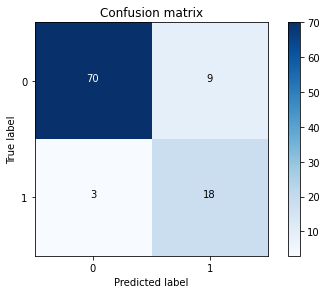

test number: 2
Test accuracy: 0.8300


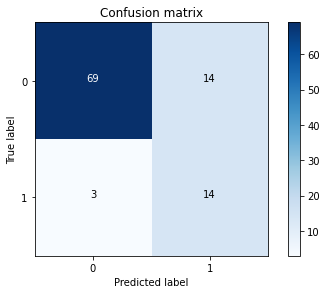

test number: 3
Test accuracy: 0.9000


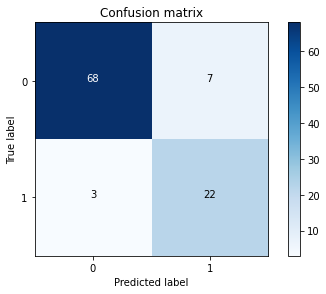

test number: 4
Test accuracy: 0.8700


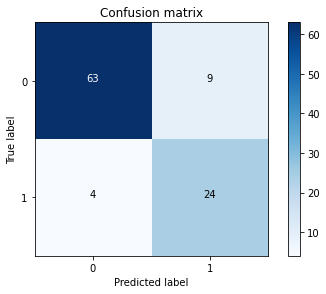

test number: 5
Test accuracy: 0.8200


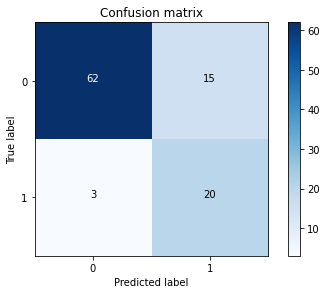

In [22]:
### and now let's see what happens if I train my model with orthonormalisation with a roguhly balanced dataset

## criterion is: criterion
criterion= nn.BCELoss()

## model
## defining the model
ds_simple_fc_bjork_balanced_model = SimpleFCClassification(network_parameters=config_train_classification_bjork['net_params'],
                                                           **additional_network_params)
ds_simple_fc_bjork_balanced_model = ds_simple_fc_bjork_balanced_model.to('cpu')
print("model is:"); print(ds_simple_fc_bjork_balanced_model)

### instantiate the Trainer 
trainer_classification_bjork_balanced = Trainer_classification(model=ds_simple_fc_bjork_balanced_model,
                                                        ###using a roughly balanced dataset
                                                        xdata=x_mat3,
                                                        ydata=y_mat3,
                                                        ###ROUGHLY BALANCED (because during splitting #class 0 DP could be not exactly = # class 1 DPs)
                                                        criterion=criterion,
                                                        config=config_train_classification_bjork,
                                                        seed=12,
                                                        device='cpu',
                                                        print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                        )

### Let's train the model
trainer_classification_bjork_balanced.train() ### 

### plotting loss curves
plot_losses_trained_model(trainer_classification_bjork_balanced)

### evaluating the trained model's performance on the test dataset
print("--------Trained model's (with orthonormalisation and trained on nearly balanced TS) performance on the test data ------")
for i in range(0, 5):
    print(f"test number: {i+1}")
    evaluate_model(ds_simple_fc_bjork_balanced_model, S_shape_label_fn, 
                    want_confusion_matrix=True, print_preds=False)


Let's compare its performance against the standard activation functions.

Tasks to do:

CONCEPTUAL TASKS:

1. Compare the classification case with the standard activation functions.
2. Check how sparse the coefficients become and some analysis of it
3. Compare the 1-D function regression case with the standard activation functions.
4. Compare the 1-D function regression case with the unconstrained (no orthonormalisation) learnable-spline case.
5. Check how sparse the coefficients become and some analysis of it.


CODING RELATED:
1. CLEAN THE NOTEBOOK `test_examples.ipynb`
2. CREATE A SEPERATE PYTHON CODE FOR THE TRAINER FOR THE CLASSIFICATION PROBLEM.

### 2. Checking the sparsity of spline coefficients of activation function

In [ ]:
with torch.no_grad():
    spline_coeffs=spline_utils.get_spline_coefficients(ds_simple_fc_model)[0].detach()
    scaling_coeff=spline_utils.get_spline_scaling_coeffs(ds_simple_fc_model)[0].detach()

In [ ]:
spline_coeffs.size(), scaling_coeff.size()

In [ ]:
spline_coeffs

In [ ]:
scaling_coeff